In [ ]:
print("Hello world")

Hello world


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#MODEL

## Installing Dependencies

In [ ]:
# 🔧 Step 1: Install Dependencies
# ------------------------------
!pip install -q ultralytics tensorflow opencv-python-headless tqdm

In [ ]:
# ------------------------------
# 🧠 Step 2: Import Libraries
# ------------------------------
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import os
import pandas as pd
from tqdm import tqdm
from ultralytics import YOLO

## Download Dataset from Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajpaswan","key":"db22a7c165902d9e91ed0ffc0a489df2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d manishlearning/20-yoga-poses-dataset

Dataset URL: https://www.kaggle.com/datasets/manishlearning/20-yoga-poses-dataset
License(s): CC0-1.0
 89% 276M/310M [00:00<00:00, 408MB/s]
100% 310M/310M [00:00<00:00, 471MB/s]


In [ ]:
!unzip 20-yoga-poses-dataset.zip

Archive:  20-yoga-poses-dataset.zip
  inflating: Yoga Dataset/Adho Mukha Svanasana/000001.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000002.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000003.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000004.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000005.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000006.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000007.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000008.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000009.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000010.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000011.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000012.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000013.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000014.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000015.png  
  inflating: Yoga Dataset/Adho Mukha Svanasana/000016.png  
  in

## Dataset checking

<ipython-input-37-d5e7aa135739>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Class', data=label_counts_df, palette='cool')


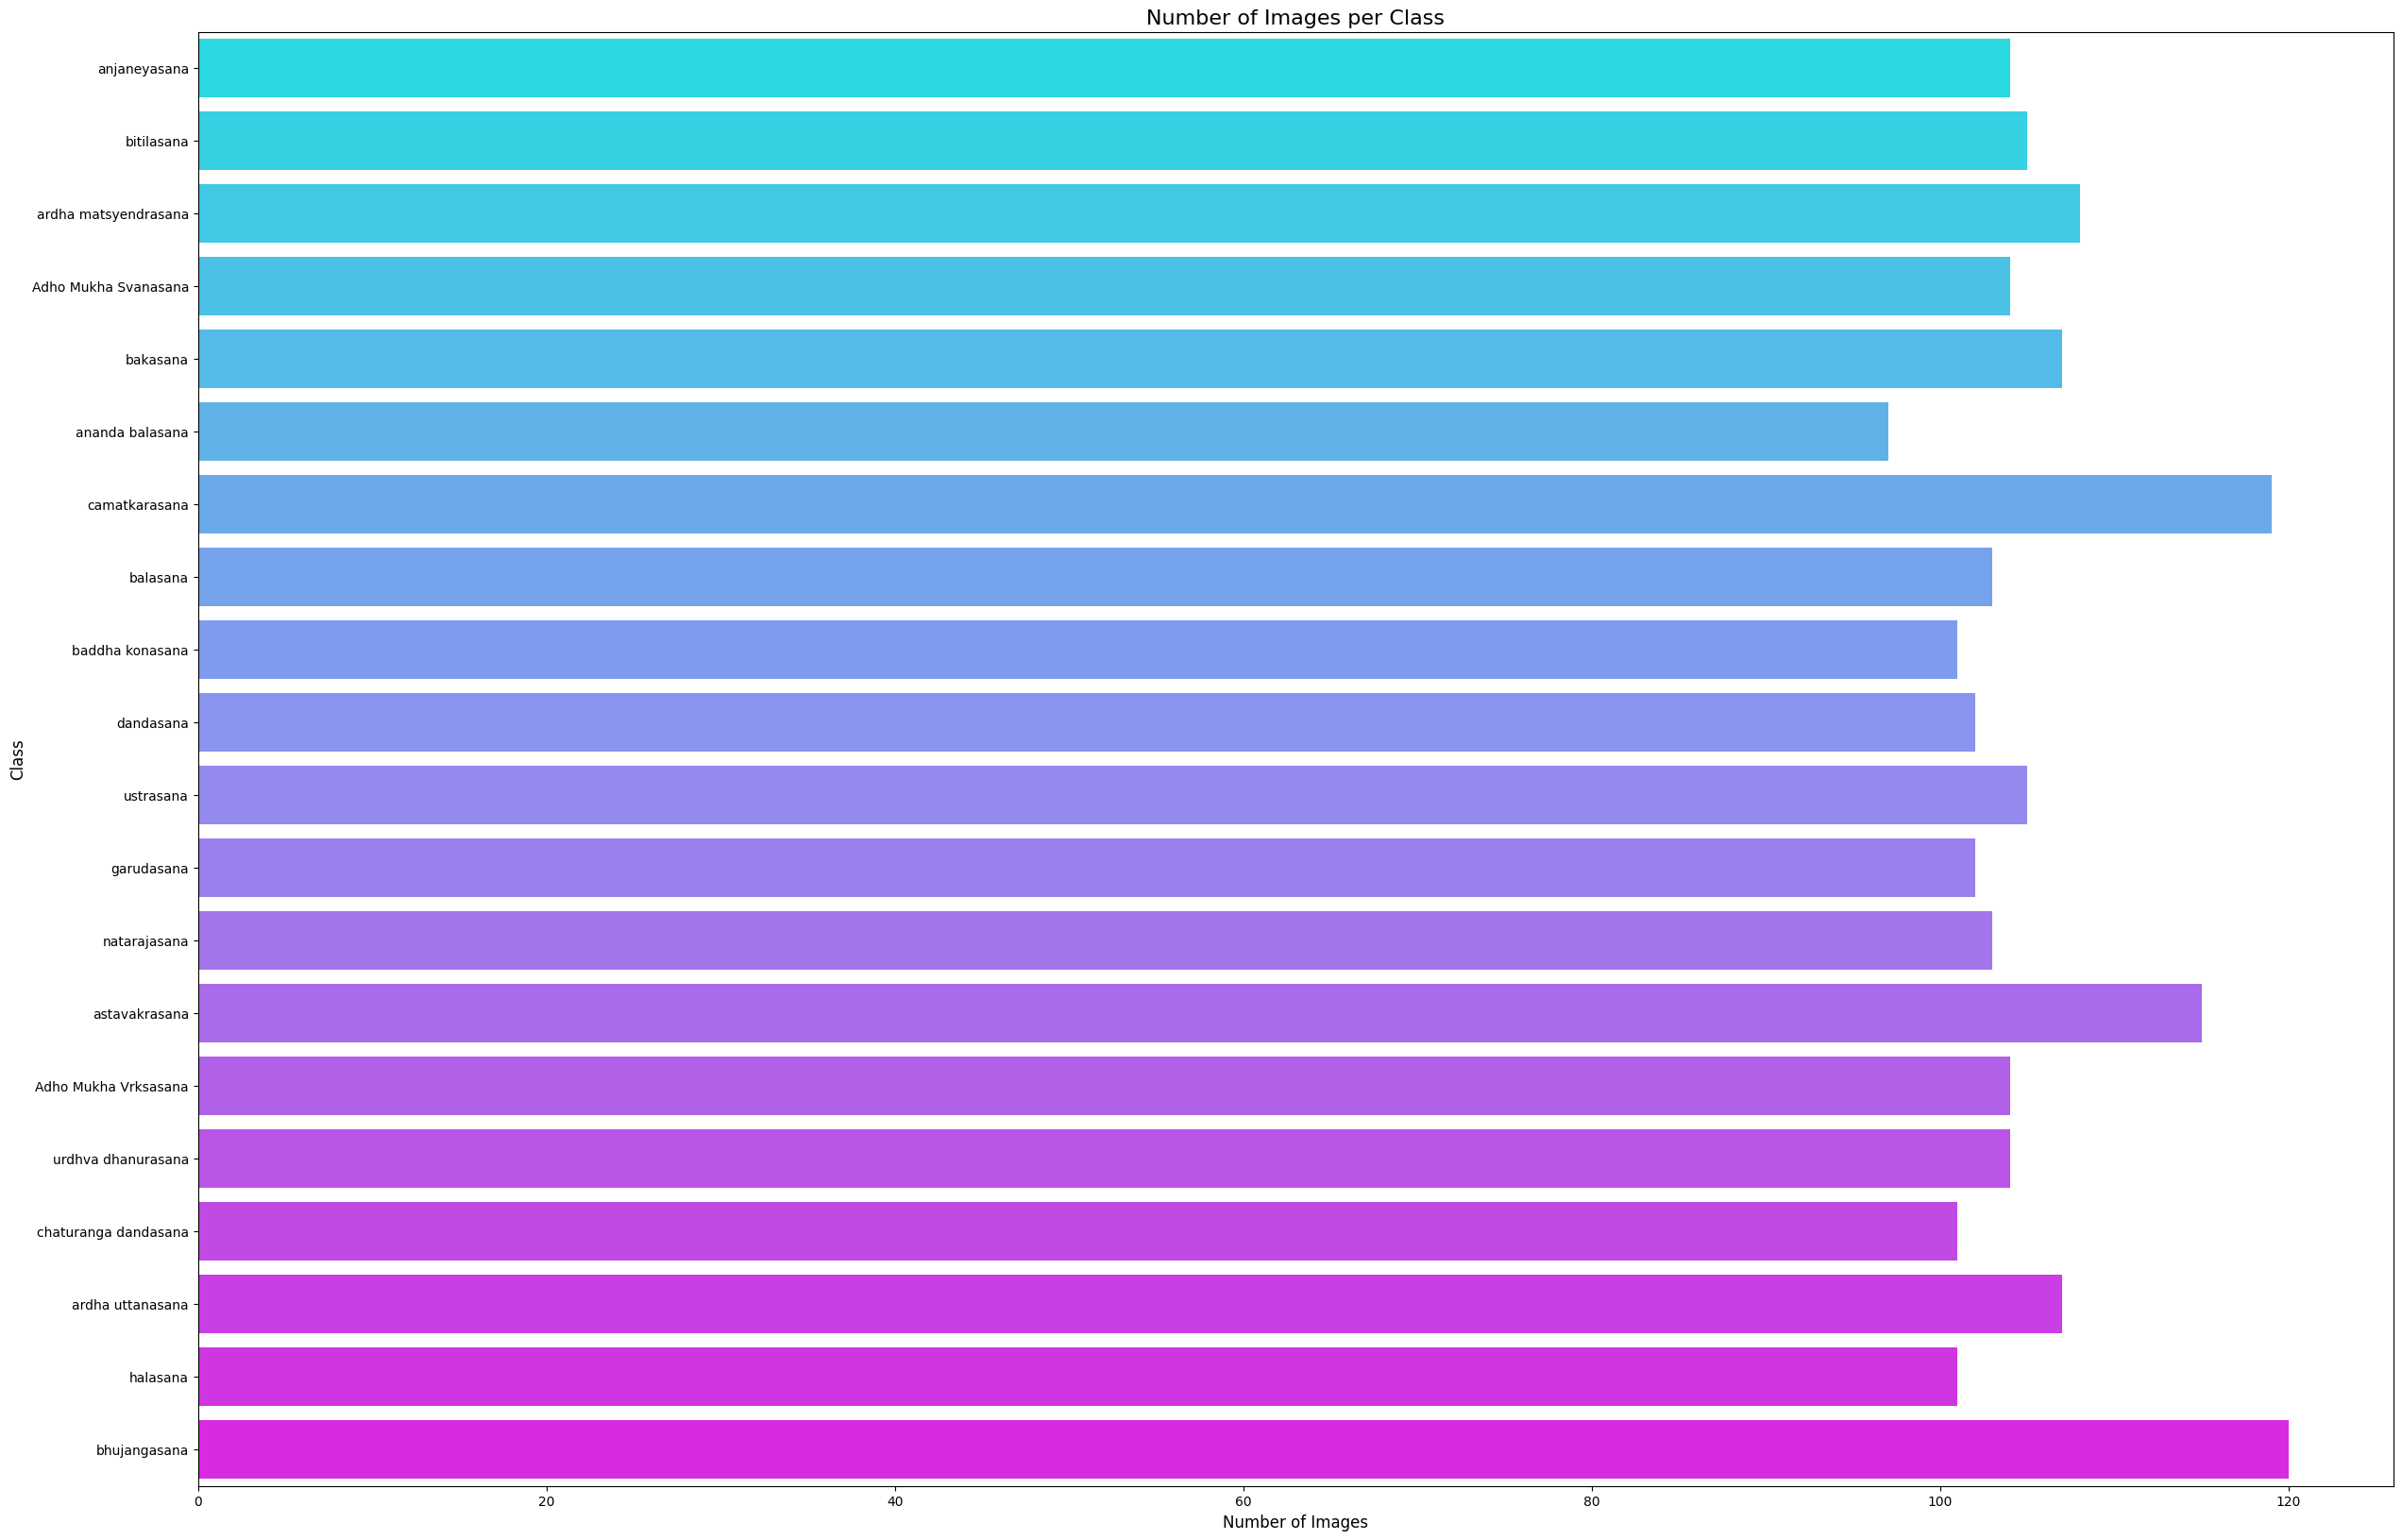

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

image_path = 'Yoga Dataset'

# Get the list of all subdirectories (classes)
classes = os.listdir(image_path)

# Initialize an empty list to store labels
labels = []

# Loop through each class and get the number of images in each class
for class_name in classes:
    class_dir = os.path.join(image_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        num_images = len(os.listdir(class_dir))  # Count number of images in each class
        labels.extend([class_name] * num_images)  # Append the class label for each image

# Count the number of images per class
label_counts = Counter(labels)

# Convert the label counts into a DataFrame for seaborn

label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Count'])

# Create the seaborn barplot
plt.figure(figsize=(30,20))
sns.barplot(x='Count', y='Class', data=label_counts_df, palette='cool')

# Add title and labels
plt.title('Number of Images per Class', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Class', fontsize=12)

# Show the plot
plt.show()

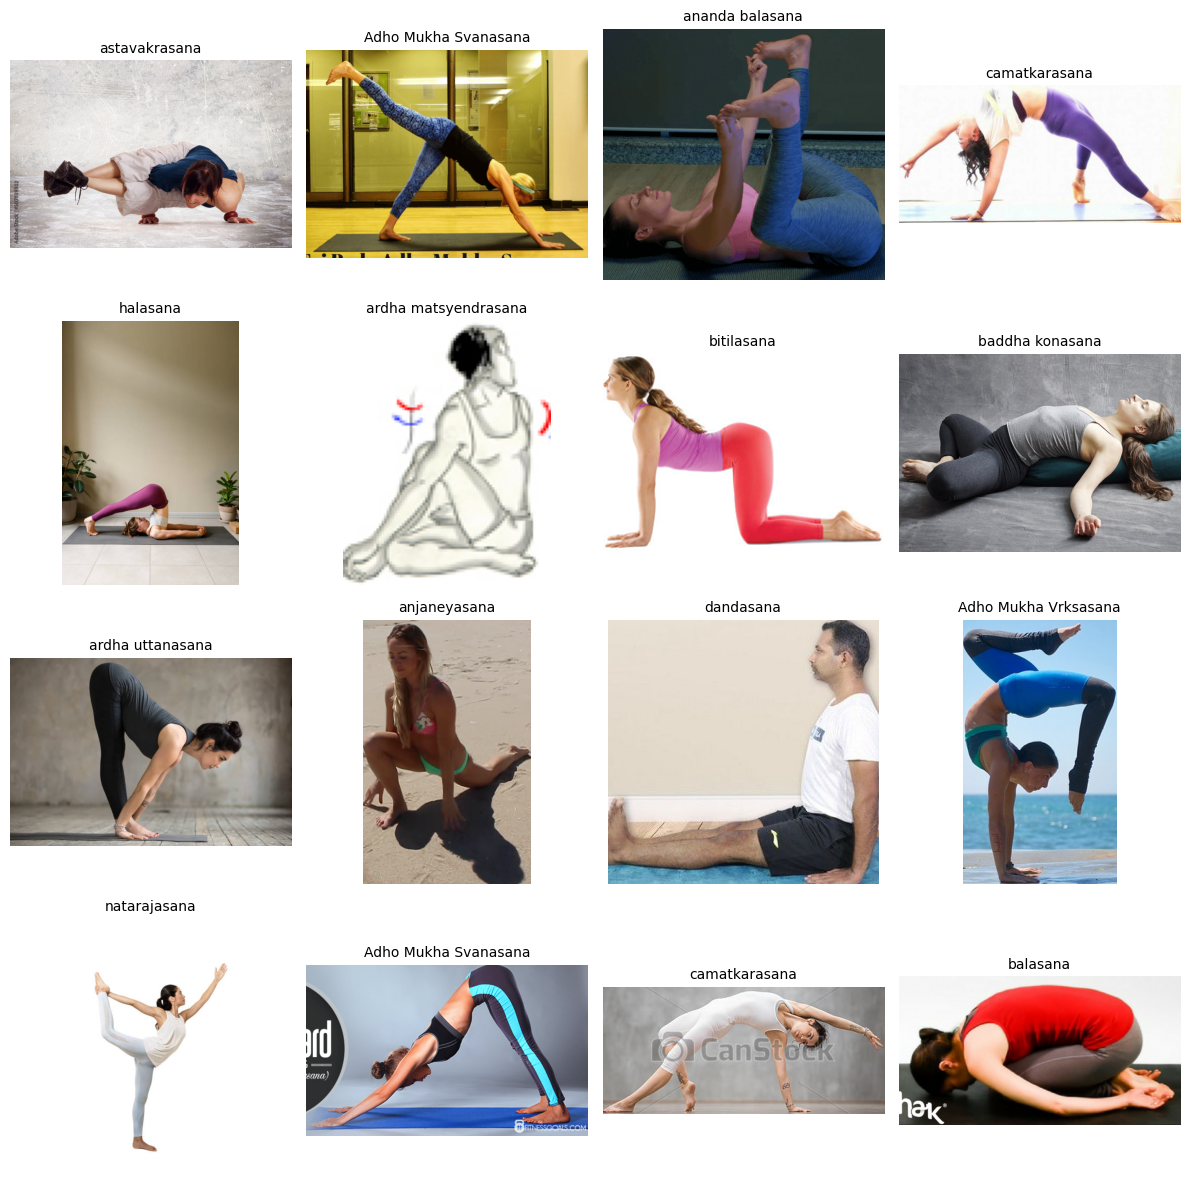

In [ ]:
# Get folder names (class labels)
class_labels = os.listdir(image_path)

# Create a list of (image_path, label) pairs
image_files = []
for label in class_labels:
    class_folder = os.path.join(image_path, label)
    if os.path.isdir(class_folder):
        images = os.listdir(class_folder)
        image_files.extend([(os.path.join(class_folder, img), label) for img in images])

# Shuffle and select 25 images
random.shuffle(image_files)
selected_images = image_files[:25]

# Plot images in a 5x5 grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    img_path, label = selected_images[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Function to extract keypoints

In [ ]:
!pip install tensorflow tensorflow-hub opencv-python-headless pandas scikit-learn


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2  # Changed to OpenCV for better channel handling
import os
import pandas as pd
from tqdm import tqdm

# Load MoveNet Thunder
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
input_size = 256  # Thunder uses 256x256 input

def detect_keypoints(image_path):
    # Read image with OpenCV (automatically drops alpha channel)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Convert BGR to RGB and ensure 3 channels
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to TensorFlow tensor
    img = tf.convert_to_tensor(img, dtype=tf.uint8)

    # Resize with padding and cast to int32
    img = tf.image.resize_with_pad(img, input_size, input_size)
    img = tf.cast(img, dtype=tf.int32)

    # Add batch dimension
    input_image = tf.expand_dims(img, axis=0)

    # Run model inference
    outputs = movenet.signatures['serving_default'](input_image)
    keypoints = outputs['output_0'].numpy()  # (1, 1, 17, 3)

    # Extract x, y coordinates only
    return keypoints[0, 0, :, :2].flatten()  # (34,) array

In [ ]:
data_dir = "Yoga Dataset"
pose_data = []

for pose_class in os.listdir(data_dir):
    pose_path = os.path.join(data_dir, pose_class)
    if not os.path.isdir(pose_path):
        continue

    for img_name in tqdm(os.listdir(pose_path), desc=f"Processing {pose_class}"):
        try:
            img_path = os.path.join(pose_path, img_name)
            keypoints = detect_keypoints(img_path)
            pose_data.append([pose_class] + keypoints.tolist())
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

# Create dataframe and save
columns = ['label'] + [f'kp_{i}_{c}' for i in range(17) for c in ['x', 'y']]
df = pd.DataFrame(pose_data, columns=columns)
df.to_csv("keypoints.csv", index=False)

Processing bhujangasana: 100%|██████████| 120/120 [00:12<00:00,  9.27it/s]


# Model Training

In [ ]:
import pandas as pd

df = pd.read_csv("yoga_keypoints.csv")
print(df.head())
print("Classes:", df['label'].unique())


          label    kp_0_x    kp_0_y    kp_1_x    kp_1_y    kp_2_x    kp_2_y  \
0  anjaneyasana  0.294093  0.389993  0.298191  0.367555  0.305237  0.361209   
1  anjaneyasana  0.325731  0.524249  0.324673  0.534398  0.325019  0.536503   
2  anjaneyasana  0.254989  0.595362  0.247075  0.572117  0.246849  0.569884   
3  anjaneyasana  0.328197  0.380957  0.317883  0.408172  0.316332  0.406291   
4  anjaneyasana  0.298781  0.460380  0.298918  0.483714  0.292360  0.476243   

     kp_3_x    kp_3_y    kp_4_x  ...   kp_12_x   kp_12_y   kp_13_x   kp_13_y  \
0  0.361240  0.357713  0.376848  ...  0.747312  0.595509  0.621769  0.897733   
1  0.334932  0.555747  0.334463  ...  0.538874  0.528577  0.584272  0.369322   
2  0.272575  0.538539  0.275675  ...  0.601759  0.525023  0.706032  0.386571   
3  0.357865  0.445826  0.352810  ...  0.749692  0.371797  0.940836  0.588238   
4  0.348203  0.522016  0.330769  ...  0.653971  0.439285  0.654803  0.200815   

    kp_14_x   kp_14_y   kp_15_x   kp_15_y   

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the CSV
df = pd.read_csv('yoga_keypoints.csv')
print(df.head())
print("Classes:", df['label'].unique())

# Encode labels to integers
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

X = df.drop(columns=['label']).values  # (n_samples, 34)
y = df['label'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


          label    kp_0_x    kp_0_y    kp_1_x    kp_1_y    kp_2_x    kp_2_y  \
0  anjaneyasana  0.294093  0.389993  0.298191  0.367555  0.305237  0.361209   
1  anjaneyasana  0.325731  0.524249  0.324673  0.534398  0.325019  0.536503   
2  anjaneyasana  0.254989  0.595362  0.247075  0.572117  0.246849  0.569884   
3  anjaneyasana  0.328197  0.380957  0.317883  0.408172  0.316332  0.406291   
4  anjaneyasana  0.298781  0.460380  0.298918  0.483714  0.292360  0.476243   

     kp_3_x    kp_3_y    kp_4_x  ...   kp_12_x   kp_12_y   kp_13_x   kp_13_y  \
0  0.361240  0.357713  0.376848  ...  0.747312  0.595509  0.621769  0.897733   
1  0.334932  0.555747  0.334463  ...  0.538874  0.528577  0.584272  0.369322   
2  0.272575  0.538539  0.275675  ...  0.601759  0.525023  0.706032  0.386571   
3  0.357865  0.445826  0.352810  ...  0.749692  0.371797  0.940836  0.588238   
4  0.348203  0.522016  0.330769  ...  0.653971  0.439285  0.654803  0.200815   

    kp_14_x   kp_14_y   kp_15_x   kp_15_y   

## Train using Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

Accuracy: 0.8770685579196218
                      precision    recall  f1-score   support

Adho Mukha Svanasana       0.84      1.00      0.91        21
Adho Mukha Vrksasana       0.95      0.88      0.91        24
     ananda balasana       1.00      1.00      1.00        32
        anjaneyasana       0.94      0.81      0.87        21
ardha matsyendrasana       0.87      1.00      0.93        27
    ardha uttanasana       0.83      0.90      0.86        21
       astavakrasana       0.70      0.83      0.76        23
     baddha konasana       0.86      0.57      0.69        21
            bakasana       0.95      0.84      0.89        25
            balasana       0.83      0.75      0.79        20
        bhujangasana       0.77      0.94      0.85        18
          bitilasana       0.88      0.88      0.88        16
       camatkarasana       0.81      0.87      0.84        15
chaturanga dandasana       0.95      1.00      0.97        18
           dandasana       0.84      0.8

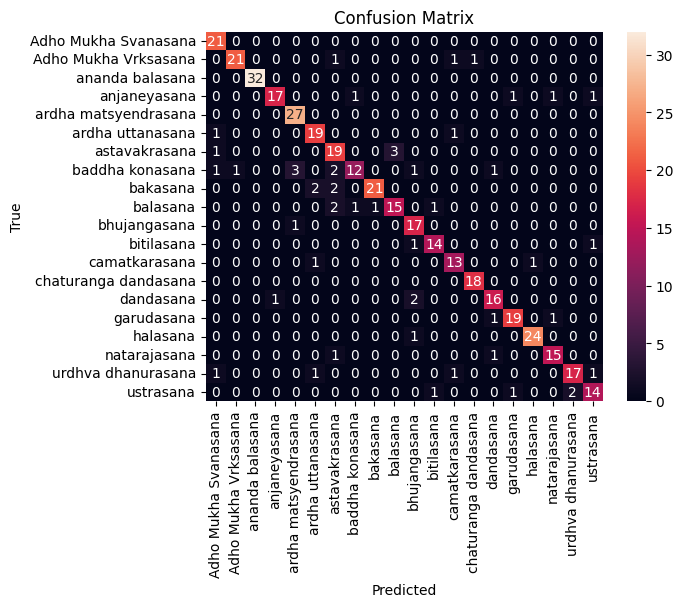

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### Performance

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


print("Accuracy:", accuracy_score(y_test, y_pred))

# Get class probabilities
y_prob = clf.predict_proba(X_test)
print("Log Loss:", log_loss(y_test, y_prob))


Accuracy: 0.8770685579196218
Log Loss: 0.6081391632792847


### Saving Model

In [ ]:
import joblib

joblib.dump(clf, 'yoga_pose.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

## Train a Neural Network on the Keypoints

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load data
df = pd.read_csv("yoga_keypoints.csv")
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

X = df.drop(columns=["label"]).values
y = tf.keras.utils.to_categorical(df['label'])  # one-hot encoded

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    Dense(128, activation='relu', input_shape=(34,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=800, batch_size=16, validation_split=0.25)
model.save("yoga_pose_nn.h5")
model.save('yoga_pose_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.0790 - loss: 2.9878 - val_accuracy: 0.1087 - val_loss: 2.8879
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0999 - loss: 2.8542 - val_accuracy: 0.2222 - val_loss: 2.6286
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1903 - loss: 2.5851 - val_accuracy: 0.3026 - val_loss: 2.3128
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2748 - loss: 2.2942 - val_accuracy: 0.4161 - val_loss: 2.0168
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3875 - loss: 2.0209 - val_accuracy: 0.5556 - val_loss: 1.7626
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4034 - loss: 1.8575 - val_accuracy: 0.6359 - val_loss: 1.5747
Epoch 7/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4856 - loss: 1.6687 - val_accuracy: 0.6998 - val_loss: 1.4300
Epoch 8/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5009 - loss: 1.5306 - val_accuracy: 0.728

### Evaluation

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}% | Loss: {loss:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9269 - loss: 0.4720 
Test Accuracy: 93.14% | Loss: 0.4505


In [ ]:
from google.colab import files

files.download("yoga_pose_nn.h5")
files.download("label_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>